In [30]:
import glob, os, json, re, unicodedata
from bs4 import BeautifulSoup

load_verbose = 0
loaded_labels = []
loaded_text = []
labels = {"Barack Obama": 0,
          "Donald J. Trump": 1,
          "Dwight D. Eisenhower": 2,
          "Franklin D. Roosevelt": 3,
          "George Bush": 4,
          "George W. Bush": 5,
          "Gerald R. Ford": 6,
          "Harry S. Truman": 7,
          "Herbert Hoover": 8,
          "Jimmy Carter": 9,
          "John F. Kennedy": 10,
          "Lyndon B. Johnson": 11,
          "Richard Nixon": 12,
          "Ronald Reagan": 13,
          "William J. Clinton": 14}

# load raw text files straight in, no parsing
file_to_label = {"Obama": "Barack Obama", 
                     "Trump": "Donald J. Trump",
                     "Eisenhower": "Dwight D. Eisenhower",
                     "Roosevelt": "Franklin D. Roosevelt",
                     "Bush": "George Bush",
                     "WBush": "George W. Bush",
                     "Ford": "Gerald R. Ford",
                     "Truman": "Harry S. Truman",
                     "Hoover": "Herbert Hoover",
                     "Carter": "Jimmy Carter",
                     "Kennedy": "John F. Kennedy",
                     "Johnson": "Lyndon B. Johnson",
                     "Nixon": "Richard Nixon",
                     "Reagan": "Ronald Reagan",
                     "Clinton": "William J. Clinton"
                    }

directory = "../data/processed/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
        arr = filename.replace(directory,'').split("_")
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 

print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."
# processed2 now contains files generated from unprocessed
directory = "../data/processed3/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
        arr = filename.replace(directory,'').split("_")
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 


print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."

Loaded 25 speeches for 2 presidents.
Loaded 1742 speeches for 15 presidents.


In [31]:
#
# Bagnall 2015 text pre-processing
#
from string import maketrans
import re

chars_to_replace = "[]%!()>=*&_\n"
sub_chars = len(chars_to_replace) * " "
trantab = maketrans(chars_to_replace, sub_chars)
for x in range(0,len(loaded_text)):
    #"Various rare characters that seemed largely equivalent are mapped together..."
    loaded_text[x] = re.sub('`', '', loaded_text[x])
    #"...all digits in all languages are mapped to 7"
    loaded_text[x] = re.sub('[0-9]', '7', loaded_text[x])
    #"...any character with a frequency lower than 1 in 10,000 is discarded." (+ \n)
    loaded_text[x] = loaded_text[x].translate(trantab)
    #"Runs of whitespace are collapsed into a single space."
    loaded_text[x] = re.sub(' +', ' ', loaded_text[x])

print "Replacements complete."

Replacements complete.


In [32]:
import numpy as np
from scipy import stats
from operator import itemgetter
from collections import defaultdict

# compress all speeches down into one massive per president
compressed_text = [None]*(len(labels))
for key, value in sorted(labels.iteritems()):
    compressed_text[value] = ""
    for idx in range(0,len(loaded_text)):
        if (loaded_labels[idx] == value):
            compressed_text[value] = compressed_text[value] + loaded_text[idx] + " "
            
print "How many characters of text per president?"
for key, value in sorted(labels.iteritems()):
    print str(value).ljust(2), ":", key.ljust(20), "\t", len(compressed_text[value])

label_min_chars = len(min(compressed_text, key=len))
print "\nMinimum number of characters per president?"
print label_min_chars

How many characters of text per president?
0  : Barack Obama         	4891166
1  : Donald J. Trump      	445782
2  : Dwight D. Eisenhower 	3109439
3  : Franklin D. Roosevelt 	2125124
4  : George Bush          	1922344
5  : George W. Bush       	1763481
6  : Gerald R. Ford       	714928
7  : Harry S. Truman      	2066478
8  : Herbert Hoover       	925075
9  : Jimmy Carter         	1294669
10 : John F. Kennedy      	1352086
11 : Lyndon B. Johnson    	2356175
12 : Richard Nixon        	992093
13 : Ronald Reagan        	987802
14 : William J. Clinton   	1762034

Minimum number of characters per president?
445782


In [33]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

# Tokenize into characters
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(compressed_text)
tokenized_text = tokenizer.texts_to_sequences(compressed_text)

unique_chars = len(tokenizer.word_counts)

print "Unique char count:", unique_chars
print "\nChars w/ counts:"
print sorted(((v,k) for k,v in tokenizer.word_counts.iteritems()), reverse=True)

Unique char count: 67

Chars w/ counts:
[(4781602, ' '), (2612968, 'e'), (2163313, 't'), (1650322, 'o'), (1630891, 'a'), (1504012, 'n'), (1426968, 'i'), (1212126, 's'), (1176131, 'r'), (1081677, 'h'), (761869, 'l'), (717147, 'd'), (557149, 'u'), (543034, 'c'), (484635, 'm'), (422412, 'w'), (396979, 'g'), (396693, 'f'), (385912, 'p'), (380068, 'y'), (284068, 'b'), (273698, '.'), (268637, ','), (242741, 'v'), (180283, 'I'), (152154, 'k'), (97593, "'"), (96524, '7'), (75237, 'A'), (68453, 'T'), (63465, 'S'), (45527, '-'), (42264, 'W'), (39078, 'N'), (36686, 'C'), (36413, 'E'), (34117, 'x'), (32963, 'P'), (29536, 'M'), (26207, 'B'), (25516, 'j'), (25008, 'R'), (23022, 'H'), (21999, 'q'), (20624, 'D'), (20284, 'O'), (19919, 'G'), (16330, 'U'), (14328, 'F'), (12993, 'L'), (12287, ':'), (12082, 'z'), (10928, '"'), (10783, 'Y'), (10572, '?'), (9734, ';'), (8803, 'J'), (5285, 'V'), (4626, 'K'), (4623, 'Q'), (4063, '$'), (1855, '/'), (585, '\\'), (455, 'Z'), (418, 'X'), (1, '}'), (1, '+')]


In [34]:
#
# Split speeches into subsequences 
#
from collections import Counter

def splits(_list, _split_size):
    output_list = []
    for idx in range(0, len(_list), _split_size):
        if (idx + _split_size) <= len(_list):
            output_list.append(_list[idx:idx + _split_size])
    return output_list

max_seq_len = 100  
label_min_chars = label_min_chars * 2

# create new speech/label holders
split_text = []
split_labels = []

for idx in range(0, len(tokenized_text)):
    current_label = idx
    current_speech = tokenized_text[idx][:label_min_chars]
    current_splits = splits(current_speech, max_seq_len)
    split_text.extend(current_splits)
    split_labels.extend([current_label] * len(current_splits))

print "Sample, label sizes:", len( split_text ), len( split_labels )
split_size = len( split_text ) / max_seq_len
print "\nTotal split groups:", split_size, "= (",len( split_text ),"/",max_seq_len,")"


Sample, label sizes: 127501 127501

Total split groups: 1275 = ( 127501 / 100 )


In [35]:
#
# Encode
#
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
import numpy as np

enc = OneHotEncoder(sparse=False,n_values=unique_chars+1,dtype=np.int)
X = np.array(split_text)
X = enc.fit_transform(X)
X = np.ndarray.reshape(X,(len( split_text ),-1,unique_chars+1))

# one-hot encode classes
y = to_categorical(split_labels)

train_test_split = .8
train_pos = int(len(split_text) * train_test_split)
train_test_split = np.split(X,[train_pos],axis=0)
train_X = train_test_split[0]
test_X = train_test_split[1]
train_y = y[:train_pos]
test_y = y[train_pos:]

print "X shape = ", X.shape
print "y shape = ", y.shape
print "\nTraining data shapes: ", train_X.shape, train_y.shape
print "\nPrepared training (", train_X.shape, "records) and test (", test_X.shape, "records) data sets."

X shape =  (127501, 100, 68)
y shape =  (127501, 15)

Training data shapes:  (102000, 100, 68) (102000, 15)

Prepared training ( (102000, 100, 68) records) and test ( (25501, 100, 68) records) data sets.


In [36]:
# #
# # train/test split
# #
# train_test_split = .8
# train_y = test_y = []
# train_y = test_X = []
# train_pos = int(len(split_text) * train_test_split)

# # train_test_split = np.split(X,[train_pos],axis=0)
# # train_X = train_test_split[0]
# # test_X = train_test_split[1]
# # train_y = y[:train_pos]
# # test_y = y[train_pos:]

# for key, value in sorted(labels.iteritems()):
#     # grab all values of a specific label
#     subset_text = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(X))
#     subset_labels = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(y))

#     print subset_text.shape
# #     trimmed_text = trimmed_text + subset_text
# #     trimmed_labels = trimmed_labels + subset_labels

# print "\nTraining data shapes: ", train_X.shape, train_y.shape
# print "\nPrepared training (", train_X.shape, "records) and test (", test_X.shape, "records) data sets."


In [37]:
#custom activation from Bagnall 2015
import tensorflow as tf

def ReSQRT(x):
    cond = tf.less_equal(x, 0)
    result = tf.where(cond, x + 0.0, tf.sqrt(x+1)-1)
    return result

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, SimpleRNN, Dropout, LSTM
from keras.optimizers import adagrad, adam, adamax, rmsprop

batch_size = 1000
epochs = 3

model = Sequential()
model.add(SimpleRNN(train_X.shape[1], activation="relu", input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))

# The network is trained using a variant of adagrad...
optimizer = adagrad(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
print(model.summary())

model.fit(train_X, y=train_y, batch_size=batch_size, epochs=epochs, verbose=1)

# Loss function: 
# Drop-out: 0
# Learning rate: < 0.01
# Optimizers: x

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 100)               16900     
_________________________________________________________________
dense_3 (Dense)              (None, 15)                1515      
Total params: 18,415
Trainable params: 18,415
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
102000/102000 [==============================] - 41s - loss: 2.5751 - categorical_accuracy: 0.0862    
Epoch 2/3
102000/102000 [==============================] - 38s - loss: 2.5163 - categorical_accuracy: 0.0873    
Epoch 3/3
102000/102000 [==============================] - 37s - loss: 2.5139 - categorical_accuracy: 0.0882    


In [39]:
# Evaluate performance
print "Evaluating test data..."
loss_and_metrics = model.evaluate(test_X, test_y)
print model.metrics_names
print loss_and_metrics

# Make some predictions
print "\nPredicting using test data..."
pred_y = model.predict(test_X, batch_size=batch_size, verbose=1)
pred_y_collapsed = np.argmax(pred_y, axis=1)
test_y_collapsed = np.argmax(test_y, axis=1)

print "Done prediction."

Evaluating test data...
25376/25501 [============================>.] - ETA: 0s['loss', 'categorical_accuracy']
[7.1857014527382006, 0.0]

Predicting using test data...
25501/25501 [==============================] - 5s     
Done prediction.


Confusion matrix, without normalization
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [ 565 1239  849  508  788   13  336  589  917  864 1003    0    0    0]
 [ 596 1517  981  576  915   15  408  656  991 1035 1225    0    0    0]
 [ 634 1441

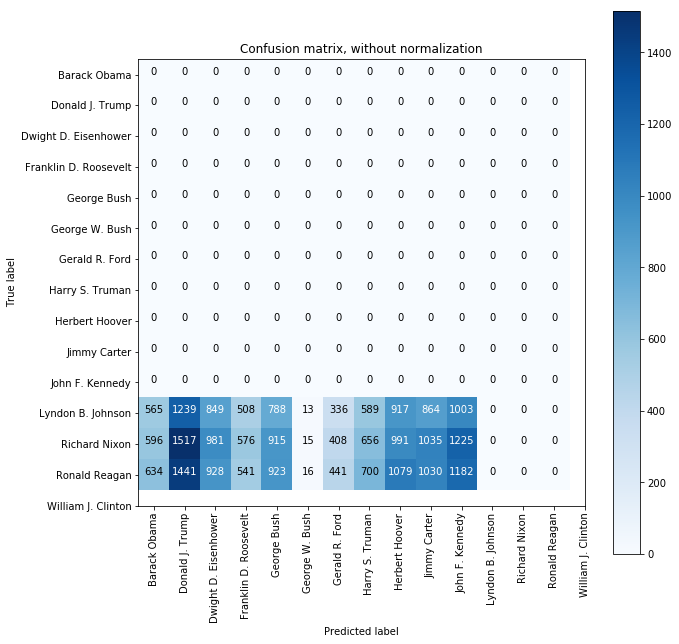

In [40]:
# from scikit-learn examples @
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y_collapsed, pred_y_collapsed)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)),
                      title='Confusion matrix, without normalization')

# #Plot normalized confusion matrix
# plt.figure(figsize=(10,10))
# plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)), normalize=True,
#                       title='Normalized confusion matrix')

plt.show()